In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [9]:
df_train = pd.read_csv('data/train.csv')
df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train['Y']


X_test_prueb = pd.read_csv('data/Xtest.csv')
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


In [10]:
X = X.astype({'X11':'category', 'X12': 'category'})
X_test_prueb = X_test_prueb.astype({'X11':'category', 'X12':'category'})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
columna = ['X11']
imputer = SimpleImputer(strategy='most_frequent')

X_train[columna] = imputer.fit_transform(X_train[columna])
X_test[columna] = imputer.fit_transform(X_test[columna])

X_train_cat = pd.DataFrame(X_train[columna])
X_test_cat = pd.DataFrame(X_test[columna])

columnas = ['X1', 'X3','X4', 'X6', 'X10', 'X7', 'X2', 'X5', 'X8', 'X9']
# columnas = ['X1', 'X6', 'X10', 'X4', 'X5']

imputer = SimpleImputer(strategy='mean')
X_train[columnas] = imputer.fit_transform(X_train[columnas])
X_test[columnas] = imputer.fit_transform(X_test[columnas])

# Convertir a un array de numpy
X_train_sub = pd.DataFrame(X_train[columnas])
X_test_sub = pd.DataFrame(X_test[columnas])

In [6]:
numerical_features = ['X1', 'X3', 'X6', 'X10', 'X4_X5', 'X2_X9']
categorical_features = ['X11']

# Merge X2 and X5
X_train_sub['X4_X5'] = (X_train_sub['X4'] + X_train_sub['X5'])
X_test_sub['X4_X5'] = (X_test_sub['X4'] + X_test_sub['X5'])
X_test_prueb['X4_X5'] = (X_test_prueb['X4'] + X_test_prueb['X5'])

X_train_sub['X2_X9'] = (X_train_sub['X9'] - X_train_sub['X2']) 
X_test_sub['X2_X9'] = (X_test_sub['X9'] - X_test_sub['X2']) 
X_test_prueb['X2_X9'] = (X_test_prueb['X9'] - X_test_prueb['X2']) 


X_train_num = X_train_sub[numerical_features]
X_train_cat = X_train[categorical_features]

X_test_num = X_test_sub[numerical_features]
X_test_cat = X_test[categorical_features]

ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)

# The real test
X_test_prueb_num = X_test_prueb[numerical_features]
X_test_prueb_cat = X_test_prueb[categorical_features]
X_prueb_cat_encoded = ohe.fit_transform(X_test_prueb_cat)

X_test_final = np.concatenate((X_test_prueb_num, X_prueb_cat_encoded), axis=1)

X_train_sub = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

param_grid_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

rf = RandomForestClassifier()

model = RandomizedSearchCV(rf, param_grid_rf, scoring='neg_log_loss', **default_grid_params)
model.fit(X_train_sub, y_train)

results = []
y_pred_proba = model.predict_proba(X_test_num)
test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)

y_pred = model.predict(X_test_num)
test_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', test_accuracy)

results.append([test_log_loss,test_accuracy])
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_final))
pred_prob_test.rename(columns={0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace=True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()

#pred_prob_test.to_csv(f"predictions_rf22.csv", index=False)


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Log loss: 0.4146510475985255
Accuracy: 0.8452073335794266


,id,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7
0,0,0.030355,0.964897,0.000000,0.0,0.004748,0.000000,0.000000
1,1,0.017761,0.978534,0.001000,0.0,0.002705,0.000000,0.000000
2,2,0.760961,0.239028,0.000000,0.0,0.000000,0.000000,0.000011
3,3,0.156398,0.787786,0.003024,0.0,0.023251,0.029541,0.000000
4,4,0.153311,0.818259,0.000000,0.0,0.000000,0.000000,0.028429


c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


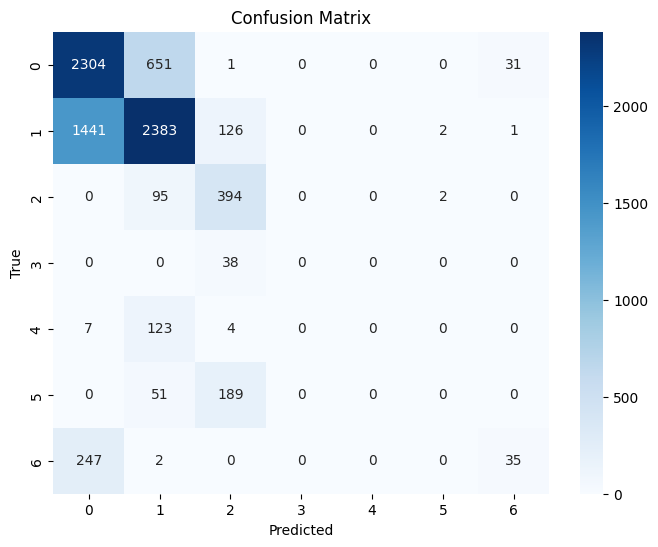

In [15]:
y_pred = model.predict(X_test_num)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear el mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
print(f'Best hyperparameters: {model.best_params_}')

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}


Here we are gonna plot a curve so we could imagine how the metrics change in relation to the n_stimators

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


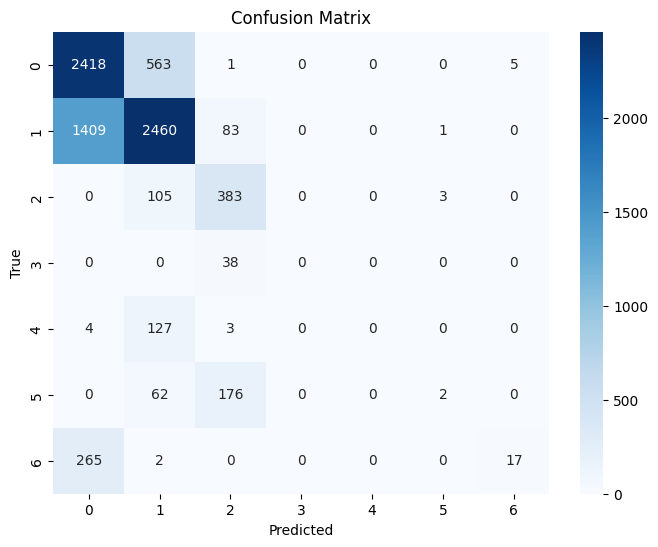

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


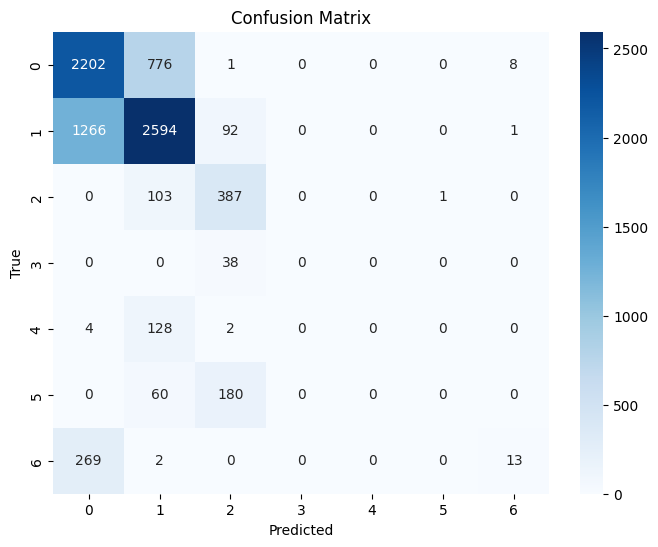

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


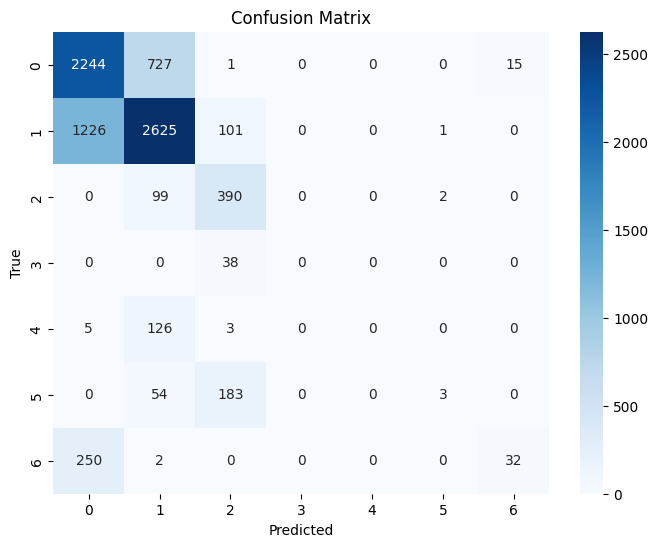

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


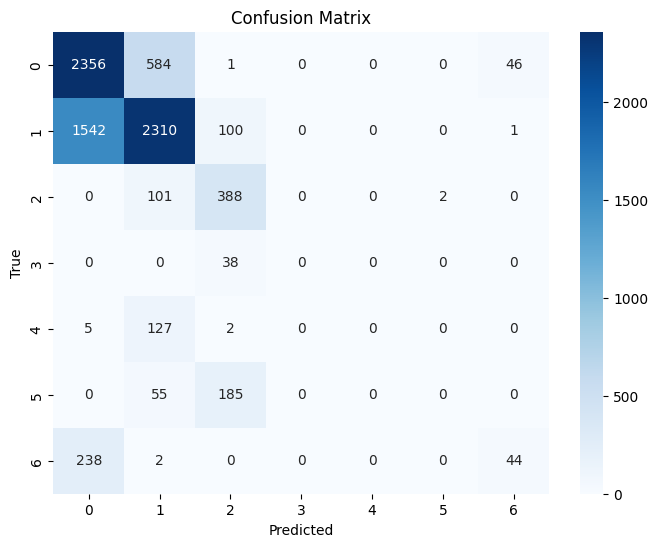

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


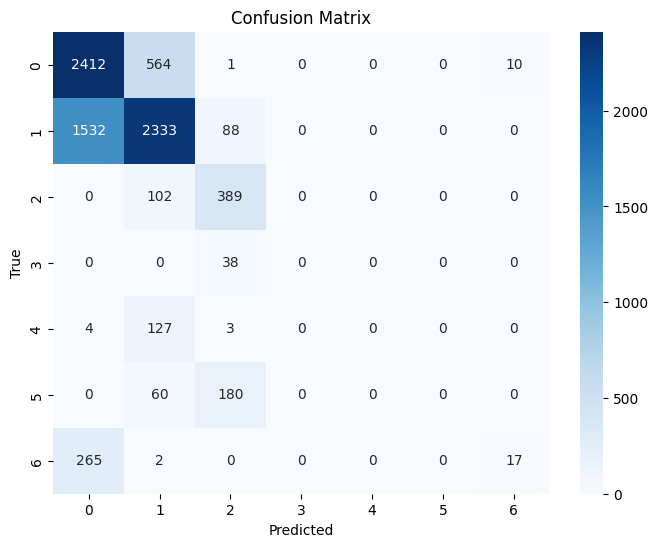

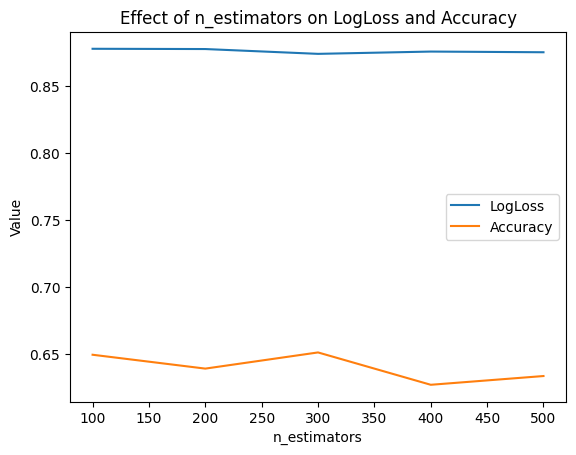

In [17]:
n_estimators = [100, 200, 300, 400, 500]


logloss_values = []
accuracy_values = []

for n in n_estimators:
    # Creating and adjunsting our model to our examples
    model = RandomForestClassifier(n_estimators=n, min_samples_leaf=2, min_samples_split=5, max_depth=None, criterion='log_loss')
    model.fit(X_train_sub, y_train) 
    
    #Predicting the 'y_test' we have created
    y_pred = model.predict(X_test_num)  # Reemplaza X_test y y_test con tus datos de prueba
    
    #Calculating LogLoss and accuracy
    logloss = log_loss(y_test, model.predict_proba(X_test_num))
    accuracy = accuracy_score(y_test, y_pred)
    
    #Adding to the lists
    logloss_values.append(logloss)
    accuracy_values.append(accuracy)
    cm = confusion_matrix(y_test, y_pred)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#Plotting the metrics
plt.plot(n_estimators, logloss_values, label='LogLoss')
plt.plot(n_estimators, accuracy_values, label='Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Value')
plt.legend()
plt.title('Effect of n_estimators on LogLoss and Accuracy')
plt.show()